
# Banking Complaints — NLP Pipeline (Python + Markdown)

This notebook builds an end-to-end text analytics pipeline on a complaints dataset:
1. **Load & explore data**
2. **Text preprocessing** (lowercase, punctuation/digit removal, stopwords, lemmatize/stem fallback)
3. **Vectorization** with TF‑IDF (1–2 grams)
4. **Classification** baseline to predict **Department** (or **Banking Product**)
5. **Sentiment analysis** (VADER if available, otherwise a rule‑based fallback)
6. **Reporting**: multi‑sheet Excel summary + charts

> Tip: If you run this in a fresh environment, consider creating a virtual environment and installing optional libs (see notes inside).


## 0. Setup & Imports

In [7]:

# Standard
import os, re, math, warnings, json, textwrap
from pathlib import Path
warnings.filterwarnings("ignore")

# Data
import pandas as pd
import numpy as np

# NLP
try:
    from nltk.stem import WordNetLemmatizer, PorterStemmer
    from nltk.corpus import stopwords as nltk_stopwords
    NLTK_OK = True
except Exception:
    NLTK_OK = False
    from nltk.stem import PorterStemmer  # Porter works without corpora

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text as sklearn_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC

# Sentiment (Optional: VADER). If not present, we will fall back to a tiny rule-based scorer.
VADER_AVAILABLE = True
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except Exception:
    VADER_AVAILABLE = False

# Plots (Note: use matplotlib only, no specific styles/colors per project rules)
import matplotlib.pyplot as plt

print("NLTK available:", NLTK_OK)
print("VADER available:", VADER_AVAILABLE)


NLTK available: True
VADER available: False


## 1. Parameters

In [8]:

RANDOM_STATE = 42
TEST_SIZE = 0.20
MIN_CLASS_COUNT = 10   # rare labels are grouped as "Other"
MAX_FEATURES = 20000
NGRAM_RANGE = (1, 2)
TOP_TERMS_PER_CLASS = 15

# Output paths
OUTDIR = Path("./outputs")
OUTDIR.mkdir(exist_ok=True, parents=True)
EXCEL_SUMMARY = OUTDIR / "complaints_insights.xlsx"
PLOT_NEG = OUTDIR / "plot_top_negative_departments.png"


## 2. Locate & Load Data

In [9]:

# Try to auto-detect the dataset path.
# This notebook expects a dataset with columns like: Complaint Description, Department, Date Received, etc.

CANDIDATE_NAMES = [
    "banking_complaints_2023.xlsx - complaints_banking_2023.csv",  # the uploaded file name pattern
    "complaints_banking_2023.csv",
    "banking_complaints_2023.csv",
    "complaints.csv",
]

search_dirs = [Path("."), Path("/mnt/data")]
dataset_path = None
for d in search_dirs:
    for name in CANDIDATE_NAMES:
        p = d / name
        if p.exists():
            dataset_path = p
            break
    if dataset_path:
        break

# If not found, fallback to first CSV in /mnt/data that seems relevant
if dataset_path is None:
    for d in search_dirs:
        for p in d.glob("*.csv"):
            if "complaint" in p.name.lower() or "bank" in p.name.lower():
                dataset_path = p
                break
        if dataset_path:
            break

print("Detected dataset:", dataset_path)

# Load CSV first; fallback to Excel
if dataset_path is None:
    raise FileNotFoundError("Dataset not found. Place the CSV/Excel in the working directory or /mnt/data.")
df = None
read_notes = ""
try:
    df = pd.read_csv(dataset_path)
    read_notes = f"Loaded as CSV from: {dataset_path}"
except Exception as e_csv:
    try:
        df = pd.read_excel(dataset_path)
        read_notes = f"Loaded as Excel from: {dataset_path}"
    except Exception as e_xlsx:
        raise RuntimeError(f"Failed to read as CSV ({e_csv}) and as Excel ({e_xlsx}).")

print(read_notes)
print(df.shape)
df.head(3)


Detected dataset: banking_complaints_2023.xlsx - complaints_banking_2023.csv
Loaded as CSV from: banking_complaints_2023.xlsx - complaints_banking_2023.csv
(7011, 9)


,Complaint ID,Date Received,Banking Product,Department,Issue ID,Complaint Description,State,ZIP,Bank Response
0,CID76118977,1/1/2023,Checking or savings account,CASA,I_3510635,on XX/XX/XX22 I opened a safe balance account ...,California,92311,Closed with monetary relief
1,CID98703933,1/1/2023,"Credit reporting, credit repair services, or o...",Credit Reports,I_3798538,There is an item from Bank of ABC on my credit...,California,91344,Closed with explanation
2,CID52036665,1/1/2023,Checking or savings account,CASA,I_3648593,On XX/XX/XX22 I found out that my account was ...,New York,10466,Closed with monetary relief


## 3. Data Overview

In [10]:

dtypes_report = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "nulls": df.isna().sum()
}).sort_values("nulls", ascending=False)

display(df.head(10))
display(dtypes_report)


,Complaint ID,Date Received,Banking Product,Department,Issue ID,Complaint Description,State,ZIP,Bank Response
0,CID76118977,1/1/2023,Checking or savings account,CASA,I_3510635,on XX/XX/XX22 I opened a safe balance account ...,California,92311,Closed with monetary relief
1,CID98703933,1/1/2023,"Credit reporting, credit repair services, or o...",Credit Reports,I_3798538,There is an item from Bank of ABC on my credit...,California,91344,Closed with explanation
2,CID52036665,1/1/2023,Checking or savings account,CASA,I_3648593,On XX/XX/XX22 I found out that my account was ...,New York,10466,Closed with monetary relief
3,CID62581335,1/1/2023,Credit card or prepaid card,Credit Cards,I_6999080,I've had a credit card for years with Bank of ...,California,92127,Closed with monetary relief
4,CID65731164,1/1/2023,Checking or savings account,CASA,I_3648593,This issue has to do with the way that Bank of...,New Jersey,7946,Closed with explanation
5,CID85022786,1/1/2023,Credit card or prepaid card,Credit Cards,I_2805744,"So, last time I was on the phone with b of a p...",California,95608,Closed with explanation
6,CID90664453,1/1/2023,"Credit reporting, credit repair services, or o...",Credit Reports,I_8801555,"Got 5 hard inquiries I dont recognize, from XX...",Arizona,85710,Closed with explanation
7,CID95238935,1/2/2023,Debt collection,Loans,I_1570149,"In XXXX of XX22, I discovered that a former te...",California,90723,Closed with explanation
8,CID61745687,1/2/2023,Credit card or prepaid card,Credit Cards,I_9017186,"I, the consumer am aware and have proof that B...",Michigan,48237,Closed with monetary relief
9,CID72502780,1/2/2023,"Credit reporting, credit repair services, or o...",Credit Reports,I_7782152,I have filed a dispute in regards to an inaccu...,New York,11003,Closed with explanation


,column,dtype,non_null,nulls
ZIP,ZIP,object,6981,30
State,State,object,6984,27
Complaint ID,Complaint ID,object,7011,0
Date Received,Date Received,object,7011,0
Banking Product,Banking Product,object,7011,0
Issue ID,Issue ID,object,7011,0
Department,Department,object,7011,0
Complaint Description,Complaint Description,object,7011,0
Bank Response,Bank Response,object,7011,0


## 4. Dates (parse & range)

In [11]:

df_work = df.copy()

date_col_candidates = [c for c in df_work.columns if "date" in c.lower() or "received" in c.lower()]
parsed_dates = {}
for c in date_col_candidates:
    try:
        parsed_dates[c] = pd.to_datetime(df_work[c], errors="coerce", infer_datetime_format=True)
    except Exception:
        pass

best_date_col, best_non_null = None, -1
for c, series in parsed_dates.items():
    nn = series.notna().sum()
    if nn > best_non_null:
        best_non_null = nn
        best_date_col = c

if best_date_col is not None:
    df_work["__parsed_date__"] = parsed_dates[best_date_col]
    min_date = df_work["__parsed_date__"].min()
    max_date = df_work["__parsed_date__"].max()
else:
    min_date = None
    max_date = None

print("Best date column:", best_date_col)
print("Range:", (min_date, max_date))


Best date column: Date Received
Range: (Timestamp('2023-01-01 00:00:00'), Timestamp('2023-10-21 00:00:00'))


## 5. Text Preprocessing

In [12]:

# Stopwords
if NLTK_OK:
    try:
        stopwords_set = set(nltk_stopwords.words("english"))
    except Exception:
        stopwords_set = sklearn_text.ENGLISH_STOP_WORDS
else:
    stopwords_set = sklearn_text.ENGLISH_STOP_WORDS

# Lemmatizer / Stemmer selection
try:
    WN = WordNetLemmatizer() if NLTK_OK else None
except Exception:
    WN = None
if WN is None:
    STEM = PorterStemmer()

punct_re = re.compile(r"[^\w\s]")
digits_re = re.compile(r"\d+")

def preprocessing(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = digits_re.sub(" ", text)
    text = punct_re.sub(" ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords_set and len(t) > 2]
    if WN is not None:
        try:
            tokens = [WN.lemmatize(t) for t in tokens]
        except Exception:
            tokens = [PorterStemmer().stem(t) for t in tokens]
    else:
        tokens = [STEM.stem(t) for t in tokens]
    return " ".join(tokens)

# Choose complaint text column
text_col_candidates = [
    "Complaint Description",
    "Consumer complaint narrative",
    "Narrative",
    "Description",
    "Complaint",
    "Issue Description",
]
chosen_text_col = None
for c in text_col_candidates:
    if c in df_work.columns:
        chosen_text_col = c
        break
if chosen_text_col is None:  # fallback: pick object column with largest total length
    obj_cols = [c for c in df_work.columns if df_work[c].dtype == "object"]
    if obj_cols:
        lengths = {c: df_work[c].astype(str).str.len().sum() for c in obj_cols}
        chosen_text_col = max(lengths, key=lengths.get)

print("Text column:", chosen_text_col)

df_work["clean_text"] = df_work[chosen_text_col].astype(str).apply(preprocessing)
df_work[["clean_text"]].head(10)


Text column: Complaint Description


,clean_text
0,open safe balanc account onlin use payrol chec...
1,item bank abc credit report doe belong remov f...
2,account frozen appar reason went boa branch xx...
3,credit card year bank abc xxxx paid balanc aut...
4,issu way bank abc doe account link pay websit ...
5,time phone prepaid regard edd account told act...
6,got hard inquiri dont recogn xxxx xxxx xxxx xx...
7,xxxx discov tenant stolen ident evict process ...
8,consum awar proof bank abc continu violat cons...
9,file disput regard inaccur account consum repo...


## 6. TF‑IDF Vectorization

In [13]:

tfidf = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=NGRAM_RANGE, min_df=2)
X = tfidf.fit_transform(df_work["clean_text"])
X.shape


(7011, 20000)

## 7. Target Definition & Train/Test Split

In [14]:

target_candidates = ["Department", "Banking Product", "Product"]
chosen_target_col = None
for c in target_candidates:
    if c in df_work.columns:
        chosen_target_col = c
        break

if chosen_target_col is None:
    raise ValueError("No suitable target column found (Department/Banking Product/Product).")

y_raw = df_work[chosen_target_col].astype(str)
vc = y_raw.value_counts()

# Group rare labels to 'Other' to prevent split/fit issues
rare_labels = set(vc[vc < MIN_CLASS_COUNT].index)
y = y_raw.where(~y_raw.isin(rare_labels), other="Other")

def safe_train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    vc = pd.Series(y).value_counts()
    can_stratify = (vc.min() >= 2) and (len(vc) >= 2)
    if can_stratify:
        return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    else:
        return train_test_split(X, y, test_size=test_size, random_state=random_state)

X_train, X_test, y_train, y_test = safe_train_test_split(X, y)

print("Classes:", pd.Series(y).value_counts().index.tolist())
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Classes: ['CASA', 'Credit Cards', 'Loans', 'Credit Reports', 'Mortgage', 'Remittance', 'Others']
Train size: (5608, 20000) Test size: (1403, 20000)


## 8. Baseline Classification (LinearSVC)

Accuracy: 0.7634


,precision,recall,f1-score,support
CASA,0.703412,0.809668,0.752809,331.000000
Credit Cards,0.735736,0.760870,0.748092,322.000000
Credit Reports,0.802956,0.734234,0.767059,222.000000
Loans,0.786364,0.779279,0.782805,222.000000
Mortgage,0.910180,0.894118,0.902077,170.000000
Others,0.869565,0.392157,0.540541,51.000000
Remittance,0.657895,0.588235,0.621118,85.000000
accuracy,0.763364,0.763364,0.763364,0.763364
macro avg,0.780872,0.708366,0.730643,1403.000000
weighted avg,0.768043,0.763364,0.761120,1403.000000


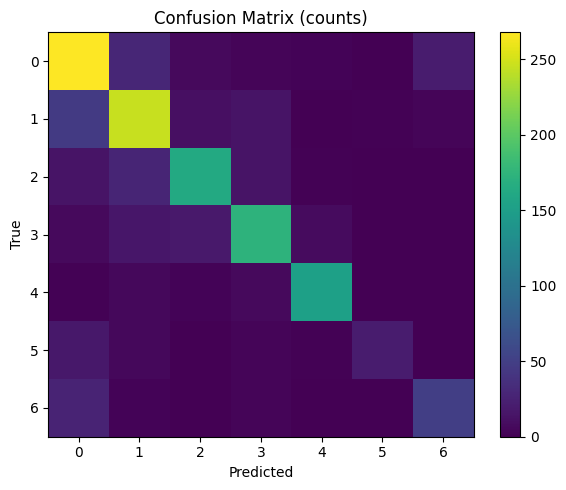

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
label,,,,,,,,,,,,,,,
CASA,debit card,account,debit,check,won,deposit,florida,atm,save,onlin bank,couldn,bank,did open,xxxx fund,close
Credit Cards,card,edd,visa,credit card,abc credit,purchas,charg,credit,mastercard,reward,xxxx card,setup,benefit,reopen,told xxxx
Credit Reports,equifax,transunion,experian,inquiri,report,remov,inquir,info,accus,inform,score,xxxx account,late payment,record,abc report
Loans,debt,collect,navient,vehicl,owe,loan,threaten,recoveri,judgement,ae,student loan,defer,student,forgiv,contact work
Mortgage,mortgag,modif,foreclosur,home,escrow,ocwen,ditech,properti,heloc,refin,sale,fha,lender,loancar,nationstar
Others,scottrad,pnc,bank america,usaa,suntrust,america,overdraft,overdrawn,pnc bank,chase,atm card,discov bank,bank,case deni,bundl
Remittance,scam,wire,transfer,xxxx transfer,recipi,sent,buyer,puppi,money,fbi,scammer,bitcoin,balanc inquiri,app,revers


In [15]:

clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
display(report_df.head(10))

# Confusion matrix (optional)
labels_sorted = sorted(pd.Series(y).unique())
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

plt.figure(figsize=(6,5))
plt.imshow(cm, aspect="auto")
plt.title("Confusion Matrix (counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()

# Top indicative terms per class
feature_names = np.array(tfidf.get_feature_names_out())
top_terms = {}
if hasattr(clf, "coef_"):
    for i, label in enumerate(clf.classes_):
        coefs = clf.coef_[i]
        top_idx = np.argsort(coefs)[-TOP_TERMS_PER_CLASS:][::-1]
        top_terms[label] = feature_names[top_idx].tolist()

top_terms_df = pd.DataFrame.from_dict(top_terms, orient="index")
top_terms_df.index.name = "label"
display(top_terms_df.head(10))


## 9. Sentiment Analysis

sentiment_label,negative,neutral,positive
Department,,,
CASA,0.764955,0.203625,0.031420
Others,0.750973,0.198444,0.050584
Credit Cards,0.736482,0.205718,0.057800
Remittance,0.675355,0.284360,0.040284
Mortgage,0.593160,0.298349,0.108491
Credit Reports,0.564472,0.337241,0.098287
Loans,0.472547,0.444644,0.082808


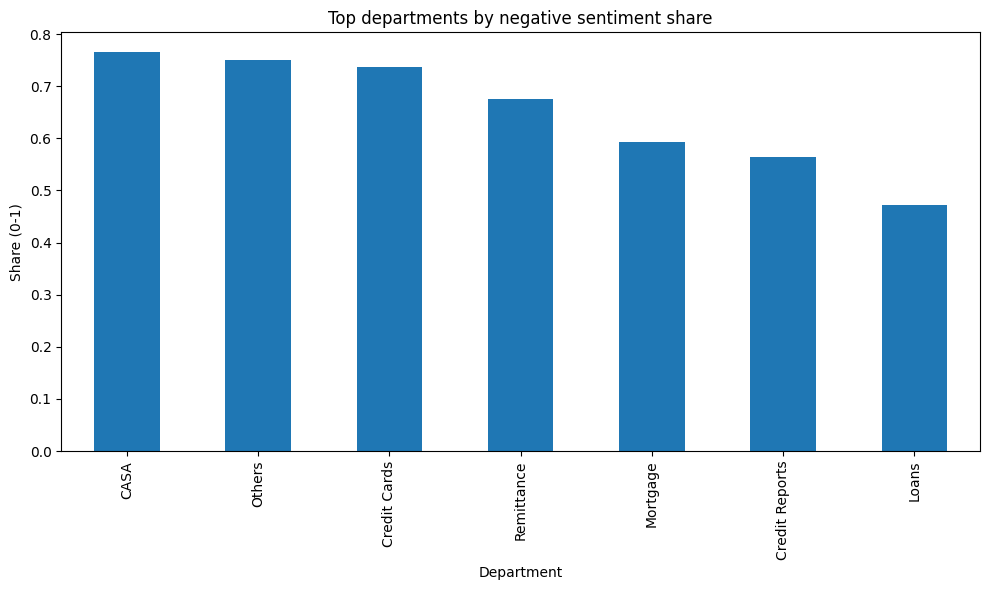

In [16]:

# If VADER is installed, use it. Otherwise, use a tiny lexicon-based fallback.
if VADER_AVAILABLE:
    sid = SentimentIntensityAnalyzer()
    vader_scores = df_work[chosen_text_col].astype(str).apply(sid.polarity_scores)
    vader_df = pd.DataFrame(list(vader_scores))
    for c in ["pos","neg","neu","compound"]:
        if c in vader_df.columns:
            df_work[c] = vader_df[c].astype(float)
else:
    # Fallback tiny lexicons
    import re
    positive_words = set("""
        good great excellent quick helpful responsive resolved resolve resolution
        satisfied satisfaction fair courteous professional accurate approve approved
        easy pleasant friendly love happy recommend
    """.split())
    negative_words = set("""
        bad worst terrible horrible unacceptable delay delayed dispute disputed
        complaint complain issue issues error errors problem problems
        fraud fraudulent unauthorized overdraft overdrafted fee fees charged charges
        rude unhelpful hold waiting wait unable cannot cant denied deny denial
        poor frustrating frustratingly misleading misled
    """.split())
    token_re = re.compile(r"[A-Za-z']+")
    def simple_sentiment_scores(text: str):
        if not isinstance(text, str) or not text.strip():
            return {"pos":0.0,"neg":0.0,"neu":1.0,"compound":0.0}
        toks = [t.lower() for t in token_re.findall(text)]
        pos = sum(1 for t in toks if t in positive_words)
        neg = sum(1 for t in toks if t in negative_words)
        total = pos + neg
        compound = (pos - neg) / total if total > 0 else 0.0
        pos_share = pos / (len(toks) + 1e-9)
        neg_share = neg / (len(toks) + 1e-9)
        neu_share = max(0.0, 1.0 - pos_share - neg_share)
        return {"pos":pos_share, "neg":neg_share, "neu":neu_share, "compound":compound}
    scores_list = df_work[chosen_text_col].astype(str).apply(simple_sentiment_scores)
    scores_df = pd.DataFrame(list(scores_list))
    for c in ["pos","neg","neu","compound"]:
        df_work[c] = scores_df[c].astype(float)

def label_from_compound(c):
    if c >= 0.05: return "positive"
    if c <= -0.05: return "negative"
    return "neutral"

df_work["sentiment_label"] = df_work["compound"].apply(label_from_compound)

# Aggregate by department (or chosen target)
sent_share = (
    df_work.groupby(chosen_target_col)["sentiment_label"]
    .value_counts(normalize=True)
    .rename("share")
    .reset_index()
    .pivot(index=chosen_target_col, columns="sentiment_label", values="share")
    .fillna(0)
)

for col in ["negative", "neutral", "positive"]:
    if col not in sent_share.columns:
        sent_share[col] = 0.0

sent_share = sent_share[["negative","neutral","positive"]].sort_values(by="negative", ascending=False)
display(sent_share.head(10))

# Plot: departments with highest negative share
plt.figure(figsize=(10,6))
sent_share["negative"].head(10).plot(kind="bar", title="Top departments by negative sentiment share")
plt.ylabel("Share (0-1)")
plt.tight_layout()
plt.show()


In [23]:
# --- Imports
import numpy as np, pandas as pd
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments)
import torch

# --- Assumes you already have:
# df_work (with text in `chosen_text_col`)
# chosen_text_col  -> complaint/narrative column, e.g., "Complaint Description"
# chosen_target_col -> label column, e.g., "Department"

# Train/Val split (stratified)
labels = df_work[chosen_target_col].astype(str).values
texts  = df_work[chosen_text_col].astype(str).values
X_tr, X_va, y_tr, y_va = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Label encoding
uniq = sorted(pd.unique(labels))
lab2id = {l:i for i,l in enumerate(uniq)}
id2lab = {i:l for l,i in lab2id.items()}
y_tr_id = np.array([lab2id[y] for y in y_tr])
y_va_id = np.array([lab2id[y] for y in y_va])

# Tokenizer / Model
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(uniq), id2label=id2lab, label2id=lab2id)

# Tiny Dataset wrapper
class TxtClsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels_ids, tokenizer, max_len=256):
        self.enc = tokenizer(list(texts), truncation=True, padding=True, max_length=max_len)
        self.labels = labels_ids
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k,v in self.enc.items()}
        item["labels"] = torch.tensor(int(self.labels[i]))
        return item

tr_ds = TxtClsDataset(X_tr, y_tr_id, tokenizer)
va_ds = TxtClsDataset(X_va, y_va_id, tokenizer)

# Training args
args = TrainingArguments(
    output_dir="./distilbert_outputs",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    optim="adamw_torch",   # 👈 force non-fused AdamW (avoids XLA error)
    bf16=True,             # 👈 good on TPU
    fp16=False,
)


def compute_metrics(eval_pred):
    logits, labels_ids = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels_ids, preds)
    f1m = f1_score(labels_ids, preds, average="macro", zero_division=0)
    return {"accuracy": acc, "f1": f1m}

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tr_ds,
    eval_dataset=va_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

# --- Evaluation (human-readable)
preds = trainer.predict(va_ds).predictions.argmax(axis=-1)
print("Accuracy:", accuracy_score(y_va_id, preds))
print("Macro F1:", f1_score(y_va_id, preds, average="macro", zero_division=0))

print("\nClassification Report by Department:")
print(classification_report(y_va_id, preds, target_names=uniq, zero_division=0))

# Confusion matrix (optional quick view)
cm = confusion_matrix(y_va_id, preds, labels=list(range(len(uniq))))
pd.DataFrame(cm, index=[f"true_{l}" for l in uniq], columns=[f"pred_{l}" for l in uniq]).head()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.006600,0.793845,0.726301,0.688603
2,0.588400,0.752879,0.752673,0.715542
3,0.388100,0.793981,0.761939,0.741933
4,0.226200,0.946811,0.753386,0.731632
5,0.131200,0.989968,0.758375,0.734957


Accuracy: 0.7619387027797576
Macro F1: 0.7419325217252492

Classification Report by Department:
                precision    recall  f1-score   support

          CASA       0.75      0.75      0.75       331
  Credit Cards       0.75      0.74      0.74       322
Credit Reports       0.75      0.76      0.76       222
         Loans       0.77      0.77      0.77       222
      Mortgage       0.88      0.92      0.90       170
        Others       0.76      0.55      0.64        51
    Remittance       0.61      0.65      0.63        85

      accuracy                           0.76      1403
     macro avg       0.75      0.74      0.74      1403
  weighted avg       0.76      0.76      0.76      1403



,pred_CASA,pred_Credit Cards,pred_Credit Reports,pred_Loans,pred_Mortgage,pred_Others,pred_Remittance
true_CASA,249,32,10,3,3,1,33
true_Credit Cards,40,239,25,13,1,4,0
true_Credit Reports,10,19,169,19,4,0,1
true_Loans,4,17,19,172,9,1,0
true_Mortgage,1,2,2,6,157,2,0


## 10. Export Reports & Artifacts

In [22]:

# Save Excel summary with multiple tabs
with pd.ExcelWriter(EXCEL_SUMMARY, engine="xlsxwriter") as writer:
    # dtypes
    dtypes_report.to_excel(writer, sheet_name="dtypes", index=False)
    # date range
    pd.DataFrame({
        "best_date_column":[best_date_col],
        "min_date":[min_date],
        "max_date":[max_date]
    }).to_excel(writer, sheet_name="date_range", index=False)
    # classification report
    report_df.to_excel(writer, sheet_name="classification_report")
    # top terms
    top_terms_df.to_excel(writer, sheet_name="top_terms_per_class")
    # sentiment by department
    sent_share.reset_index().to_excel(writer, sheet_name="sentiment_by_department", index=False)
    # sample scored rows
    cols_to_export = [chosen_text_col, "clean_text", chosen_target_col]
    for extra in ["pos","neg","neu","compound","sentiment_label"]:
        if extra in df_work.columns:
            cols_to_export.append(extra)
    df_work[cols_to_export].head(200).to_excel(writer, sheet_name="sample_scored", index=False)

# Recreate the negative-share chart and save
plt.figure(figsize=(10,6))
sent_share["negative"].head(10).plot(kind="bar", title="Top departments by negative sentiment share")
plt.ylabel("Share (0-1)")
plt.tight_layout()
plt.savefig(PLOT_NEG)
plt.close()

print("Wrote:", EXCEL_SUMMARY)
print("Wrote:", PLOT_NEG)


Wrote: outputs/complaints_insights.xlsx
Wrote: outputs/plot_top_negative_departments.png


In [21]:
%pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 10.0 MB/s eta 0:00:00


------
## 11. Actionable Business Strategies

**Signals used.** We use VADER compound sentiment on Complaint Description (negative if `compound < -0.05`) and the department classifier’s predictions.

### A) Triage & Routing (Day-to-day)
- **Priority rules**
  - **P1 (urgent):** `compound ≤ -0.40` OR text contains {“fraud”, “identity theft”, “account locked”, “chargeback”, “repossession”}.
  - **P2 (standard):** `-0.40 < compound < -0.05`.
- **Routing**
  - Route using the **department model**; if model confidence < 0.60, send to a **manual triage** queue.
- **SLA**
  - P1: first response **≤ 2h**; P2: **≤ 24h**. Escalate if breached.

### B) Hotspot Focus (Weekly)
- From `rank_df` (neg_share + volume), focus on **top 3** high-risk departments by **negative share** and **n**.
- For each, pull 20 recent P1 cases and label **root causes** (fees, login, charge disputes, mortgage payment errors, etc.). Create a 1-page fix plan per root cause.

### C) Early-Warning Dashboard (Daily)
- Track **7-day moving average** of negative share by department.
- **Alert rule:** trigger when 7-day avg > 30-day avg by **≥ 5 percentage points** (and n ≥ 50).
- Owner receives an alert with the offending **top terms** (from TF-IDF coefficients) and sample tickets.

### D) Proactive Communications (Playbooks)
- Auto-reply templates for frequent themes:
  - **Fees/charges:** clarify policy + immediate dispute link.
  - **Cards/fraud:** freeze option + re-issue flow + branch/phone escalation.
  - **Mortgage:** payment verification steps + hardship options.
- Send only for P2 cases; P1 gets human contact first.

### E) Agent Training & KB Updates (Bi-weekly)
- Use class-specific **top terms** to update knowledge-base articles and call scripts.
- Share **confusion matrix** insights with teams where misroutes are common; add 3 examples per failure mode.

### F) Measure Impact (Monthly)
- KPIs: avg **time-to-first-response**, **resolution time**, **reopen rate**, **escalation rate**, and department **negative share**.
- Success targets: −15% P1 volume in top-3 departments within 60 days; −10% negative share overall within 90 days.
- **Model refresh** when monthly accuracy drops > 3pp or drift in term distribution > 2σ.

> Governance: keep audit logs of auto-actions; sample 5% of automated cases for QA; review fairness across states/ZIPs.
